In [1]:
import QDYN
import matplotlib.gridspec as gridspec
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from glob import glob
from os.path import join

In [2]:
%matplotlib inline

In [3]:
from src.notebook_plots_v1 import (
    plot_pulse_delta_smoothing, render_pulse_delta_smoothing,
    collect_noise_table, combine_noise_tables, render_pulse_delta_smoothing)
from src.pulse_smoothing_v1 import pulse_delta_smoothing, smooth_pulse_savgol

In [4]:
def rf_sort_key(rf):
    """Key for sorting runfolder according to number of trajectories"""
    try:
        a, b = rf.split('_ntrajs')
        return (a, int(b))
    except ValueError:
        return (rf, 0)

## How does the noise in the optimized pulses scale with the number of trajectories?

In [5]:
ROOT = './data/method_comparison_dicke2/'

In [6]:
rfs_independent_trajs =  sorted(
    glob(join(ROOT, 'T5_independent_ntrajs*')), key=rf_sort_key)

In [7]:
rfs_cross_trajs =  sorted(
    glob(join(ROOT, 'T5_cross_ntrajs*')), key=rf_sort_key)

In [8]:
rf_rho = join(ROOT, 'T5_rho_ntrajs1')

In [9]:
noise_table = combine_noise_tables([
    collect_noise_table(
        rfs_independent_trajs, smooth_pulse_savgol,
        window_length=5, polyorder=3),
    collect_noise_table(
        rfs_cross_trajs, smooth_pulse_savgol,
        window_length=5, polyorder=3)],
    ['independent', 'cross'])

In [10]:
noise_table

,ν1 independent,ν2 independent,ν1 cross,ν2 cross
2,0.308018,0.055326,0.422073,0.054965
4,0.239481,0.036399,0.259226,0.040307
8,0.173078,0.025502,0.227447,0.037765
16,0.126626,0.019089,0.165143,0.026777
32,0.086187,0.013342,0.149601,0.022253
64,0.062062,0.009940,0.092641,0.014166
128,0.040879,0.006764,0.068443,0.011324


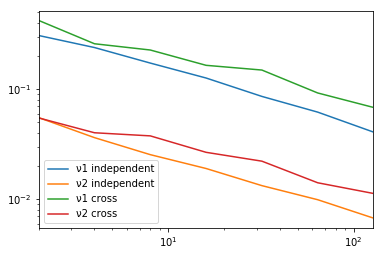

In [11]:
noise_table.plot(logx=True, logy=True)
plt.show()

### Power law identification

In [12]:
from scipy.stats import linregress

In [13]:
def loglog_linregress(df, col):
    Y = np.log(df[col])
    X = np.log(df.index)
    return linregress(X, Y)

In [14]:
def identify_powerlaw(df):
    slope_s = []
    a_s = []
    err_s = []
    for col in df.columns:
        slope, intercept, _, _, err = loglog_linregress(df, col)
        slope_s.append(slope)
        a_s.append(np.exp(intercept))
        err_s.append(err)
    return pd.DataFrame(OrderedDict([
        ('power', slope_s), ('standard error', err_s),
        ('proportionality factor', a_s)]),
        index=df.columns)

In [15]:
identify_powerlaw(noise_table)

,power,standard error,proportionality factor
ν1 independent,-0.487245,0.014036,0.462426
ν2 independent,-0.491990,0.009976,0.074158
ν1 cross,-0.408821,0.028438,0.524247
ν2 cross,-0.379204,0.025059,0.074355


### How dependent is this on the smoothing parameters?

In [16]:
def plot_integr_noise_over_trajs_for_smoothing_param_variation():
    w_p = [(5, 3), (7, 3), (11, 3), (11, 5)]
    n = len(w_p)
    fig, axs = plt.subplots(
        nrows=1, ncols=n, figsize=(6*n, 4), sharey=True, sharex=True)
    fig = plt.figure(figsize=(6*n, 6))
    for i, (w, p) in enumerate(w_p):
        noise_table = combine_noise_tables([
            collect_noise_table(
                rfs_independent_trajs, smooth_pulse_savgol,
                window_length=w, polyorder=p),
            collect_noise_table(
                rfs_cross_trajs, smooth_pulse_savgol,
                window_length=w, polyorder=p)],
            ['independent', 'cross'])
        ax = axs[i]
        noise_table.plot(ax=ax, loglog=True, title='w=%d, p=%d' % (w, p))
        ax.set_xlabel('number of trajectories')
        ax.set_ylabel('integrated noise')
    plt.show(fig)

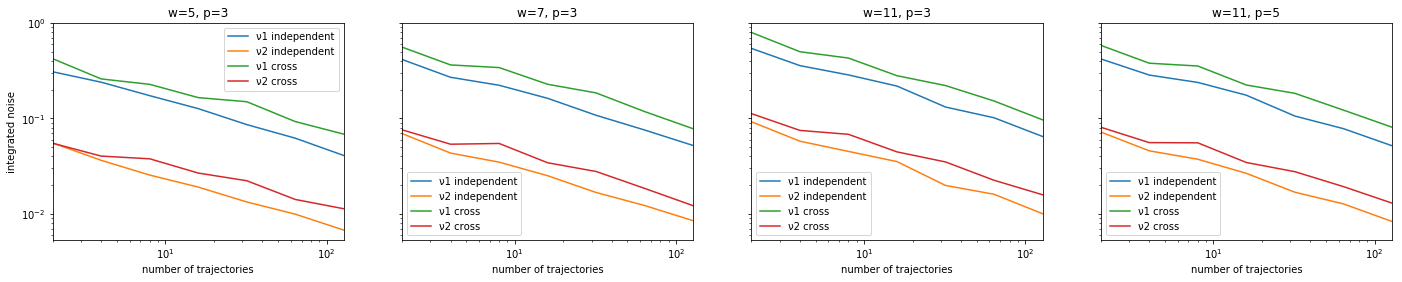

In [17]:
plot_integr_noise_over_trajs_for_smoothing_param_variation()

In [18]:
def tabulate_powerlaw_for_smoothing_param_variation():
    w_p = [(5, 3), (7, 3), (11, 3), (11, 5)]
    n = len(w_p)
    tables = []
    for i, (w, p) in enumerate(w_p):
        noise_table = combine_noise_tables([
            collect_noise_table(
                rfs_independent_trajs, smooth_pulse_savgol,
                window_length=w, polyorder=p),
            collect_noise_table(
                rfs_cross_trajs, smooth_pulse_savgol,
                window_length=w, polyorder=p)],
            ['independent', 'cross'])
        df_powerlaw = identify_powerlaw(noise_table)
        new_index = pd.MultiIndex.from_product(
            [list(df_powerlaw.index), [(w, p)]],
            names=['', 'smoothing params'])
        df_powerlaw.set_index(new_index, inplace=True)
        tables.append(df_powerlaw)
    return pd.concat(tables).unstack()

In [19]:
tabulate_powerlaw_for_smoothing_param_variation()

power                               standard error  \
smoothing params    (5, 3)    (7, 3)   (11, 3)   (11, 5)         (5, 3)   
                                                                          
ν1 cross         -0.408821 -0.451766 -0.482192 -0.455541       0.028438   
ν1 independent   -0.487245 -0.489085 -0.497777 -0.498435       0.014036   
ν2 cross         -0.379204 -0.427532 -0.460635 -0.427768       0.025059   
ν2 independent   -0.491990 -0.492920 -0.516851 -0.506200       0.009976   

                                               proportionality factor  \
smoothing params    (7, 3)   (11, 3)   (11, 5)                 (5, 3)   
                                                                        
ν1 cross          0.030083  0.021818  0.026782               0.524247   
ν1 independent    0.017101  0.020963  0.022906               0.462426   
ν2 cross          0.035481  0.024107  0.029752               0.074355   
ν2 independent    0.014245  0.024390  0.017386               0.074158   

                                                
smoothing params    (7, 3)   (11, 3)   (11, 5)  
                                                
ν1 cross          0.777638  1.087632  0.805058  
ν1 independent    0.582326  0.772126  0.616847  
ν2 cross          0.109814  0.157853  0.113493  
ν2 independent    0.094137  0.129739  0.101200

Cross-trajectory might scale less than $\sqrt{N}$, but there's too few points to make this an exact statement

How does the noise actually look for the different smoothing parameters, for the example of two trajectories?

In [20]:
def plot_noise_over_time_for_smoothing_param_variation(rf):
    w_p = [(5, 3), (7, 3), (11, 3), (11, 5)]
    n = len(w_p)
    fig, axs = plt.subplots(
        nrows=1, ncols=n, figsize=(6*n, 4), sharey=True, sharex=True)
    for i, (w, p) in enumerate(w_p):
        ax = axs[i]
        render_pulse_delta_smoothing(
            ax, rf, smooth_pulse_savgol, window_length=w, polyorder=p)
        ax.set_title('w=%d, p=%d' % (w, p))
        ax.set_xlabel('time')
        ax.set_ylabel('noise')
    plt.show(fig)

In [21]:
def select_ntrajs(runfolders, ntrajs):
    """Select the runfolder with the matching `ntrajs` from the list of
    `runfolders`"""
    return ([
        rf for rf in runfolders
        if rf.endswith('ntrajs%d' % ntrajs)][0])

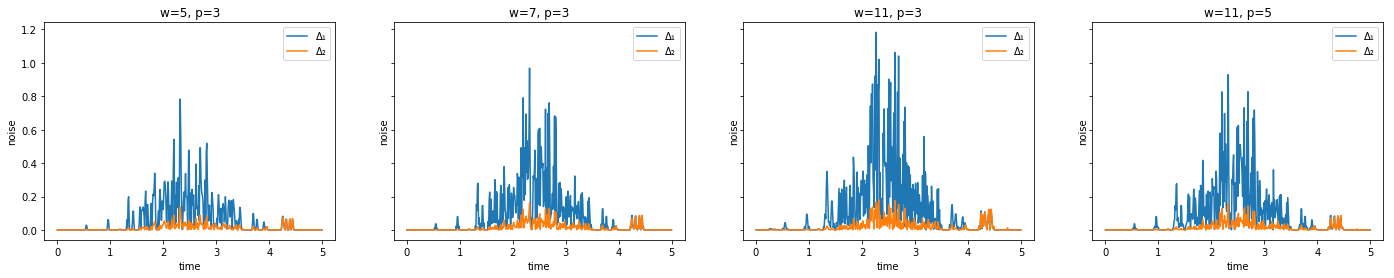

In [22]:
plot_noise_over_time_for_smoothing_param_variation(
    rf=select_ntrajs(rfs_independent_trajs, 2))

## How do the noise spectra compare?

There's the hypothesis that the frequency of the noise is higher for cross-trajectory optimization, because if there is a jump in *any* trajectory, this will lead to noise in pulse update. One might expect that the noise happens with higher frequency

In [23]:
def plot_noise_over_time_for_independent_or_cross(rf_cross, rf_independent):
    n = 2
    fig, axs = plt.subplots(
        nrows=1, ncols=n, figsize=(8*n, 5), sharey=True, sharex=True)
    pulse1_independent = QDYN.pulse.Pulse.read(
        join(rf_independent, 'pulse1.oct.dat'))
    pulse1_cross = QDYN.pulse.Pulse.read(
        join(rf_cross, 'pulse1.oct.dat'))
    pulse2_independent = QDYN.pulse.Pulse.read(
        join(rf_independent, 'pulse2.oct.dat'))
    pulse2_cross = QDYN.pulse.Pulse.read(
        join(rf_cross, 'pulse2.oct.dat'))
    pulses = [
        pulse1_independent, pulse1_cross, pulse2_independent, pulse2_cross]
    delta = pulse_delta_smoothing(
        pulses, smooth_pulse_savgol, window_length=5, polyorder=3)

    axs[0].set_title('independent')
    axs[0].plot(delta[0].tgrid, np.abs(delta[0].amplitude), label='indep.')
    axs[0].plot(delta[1].tgrid, np.abs(delta[1].amplitude), label='cross')
    axs[0].set_title('Δ₁')

    axs[1].set_title('independent')
    axs[1].plot(delta[2].tgrid, np.abs(delta[2].amplitude), label='indep.')
    axs[1].plot(delta[3].tgrid, np.abs(delta[3].amplitude), label='cross')
    axs[1].set_title('Δ₂')

    for ax in axs:
        ax.set_xlabel("time")
        ax.set_ylabel("noise amplitude")
        ax.legend()

    plt.show(fig)

We first look at the noise signal directly (before going to the spectrum)

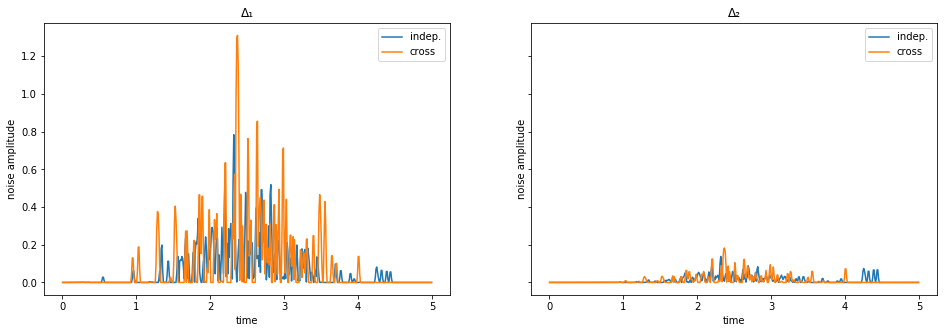

In [24]:
plot_noise_over_time_for_independent_or_cross(
    rf_cross=select_ntrajs(rfs_cross_trajs, 2),
    rf_independent=select_ntrajs(rfs_independent_trajs, 2))

No real obvious difference (besides the amplitude)

In [25]:
def plot_noise_spectrum_for_independent_or_cross(
        rf_cross, rf_independent, normalize=False):
    n = 2
    fig, axs = plt.subplots(
        nrows=1, ncols=n, figsize=(8*n, 5), sharey=True, sharex=True)
    pulse1_independent = QDYN.pulse.Pulse.read(
        join(rf_independent, 'pulse1.oct.dat'))
    pulse1_cross = QDYN.pulse.Pulse.read(
        join(rf_cross, 'pulse1.oct.dat'))
    pulse2_independent = QDYN.pulse.Pulse.read(
        join(rf_independent, 'pulse2.oct.dat'))
    pulse2_cross = QDYN.pulse.Pulse.read(
        join(rf_cross, 'pulse2.oct.dat'))
    pulses = [
        pulse1_independent, pulse1_cross, pulse2_independent, pulse2_cross]
        
    delta = pulse_delta_smoothing(
        pulses, smooth_pulse_savgol, window_length=5, polyorder=3)
    
    # renormalize
    if normalize:
        for i in range(len(pulses)):
            delta[i].amplitude /= np.max(np.abs(delta[i].amplitude))

    axs[0].set_title('independent')
    delta[0].render_spectrum(axs[0], label='indep.')
    delta[1].render_spectrum(axs[0], label='cross')
    axs[0].set_title('Δ₁')

    axs[1].set_title('independent')
    delta[2].render_spectrum(axs[1], label='indep.')
    delta[3].render_spectrum(axs[1], label='cross')
    axs[1].set_title('Δ₂')

    for ax in axs:
        ax.set_xlabel("frequency")
        ax.set_ylabel("noise amplitude")
        ax.legend()

    plt.show(fig)

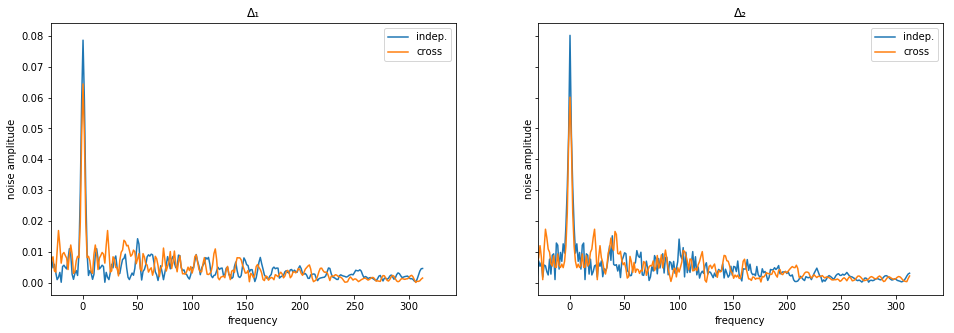

In [26]:
plot_noise_spectrum_for_independent_or_cross(
    rf_cross=select_ntrajs(rfs_cross_trajs, 2),
    rf_independent=select_ntrajs(rfs_independent_trajs, 2),
    normalize=True)

No evidence for higher frequencies in the noise!